In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import gamma, norm, chi2, t
from seaborn_qqplot import pplot
import statsmodels.api as sm
import scipy.stats as stats
from math import sqrt
import numpy as np

In [2]:
df = pd.read_csv('framingham_heart_disease.csv')

# Hypothesis question:
## Experimental question - Does BMI (X) change between gender (Y)

### Empirical mean of each category

In [3]:
df_male = df[df['male']==1]
df_male['BMI'].mean()

26.18565600882029

In [4]:
df_female = df[df['male']==0]
df_female['BMI'].mean()

25.512636174636253

### Confidence interval
Our estimated confidence interval is: $\hat{\theta_n} \pm 2\cdot \hat{se}$, where $\hat{\theta_n} = \bar{X_n}$ is the MLE estimator for the expectation.


**Checking the distribution of BMI values in order to calculate $\hat{se}$**

Text(0.5, 1.0, 'Female')

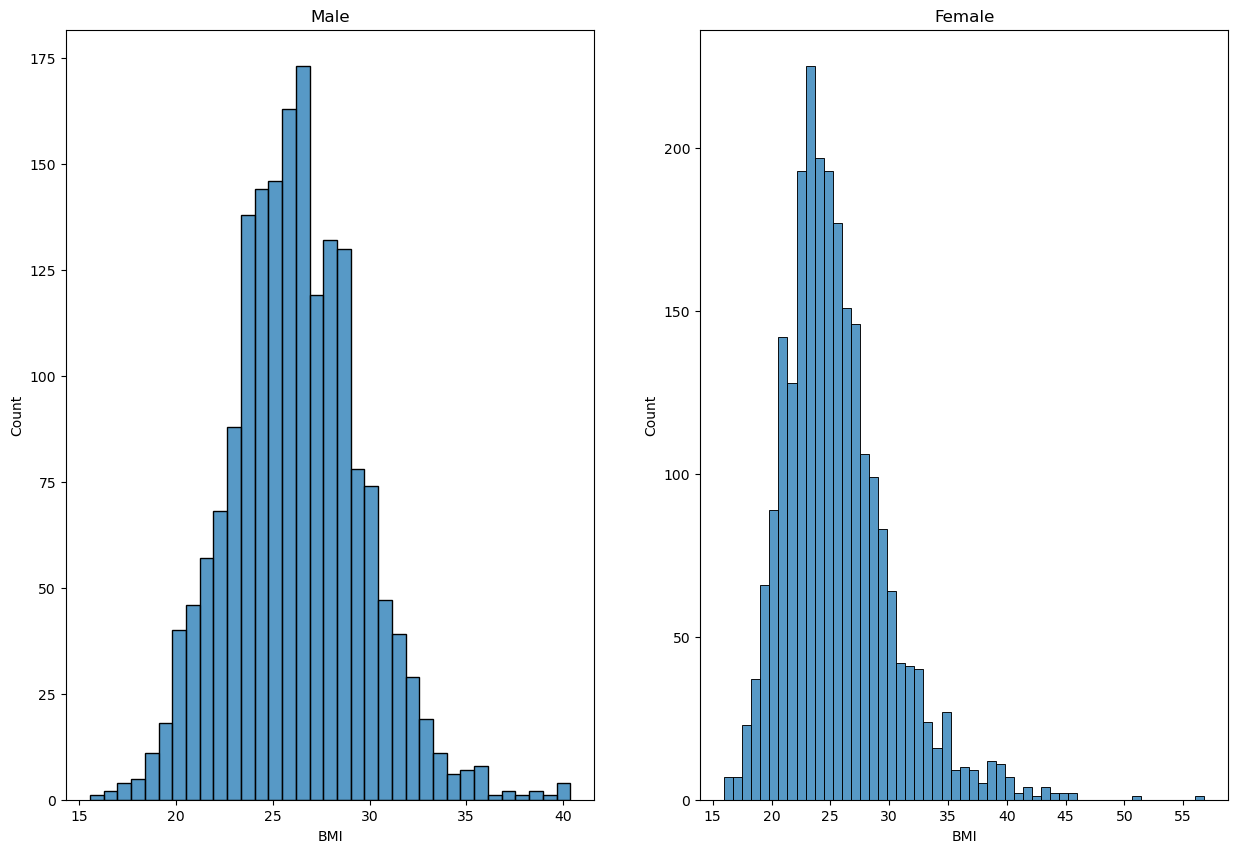

In [5]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,10))
sns.histplot(data=df[df['male']== 1], x='BMI', ax=axes[0]).set_title('Male')
sns.histplot(data=df[df['male']== 0], x='BMI', ax=axes[1]).set_title('Female')

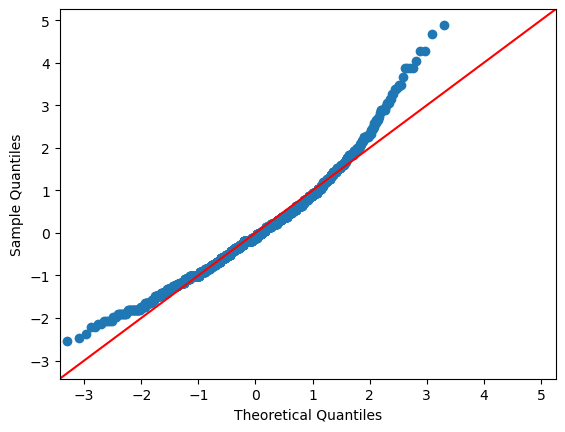

In [6]:
# Female QQPlot
fig = sm.qqplot(df[df['male']== 0].dropna()['diaBP'].values, stats.norm, fit=True, line="45")

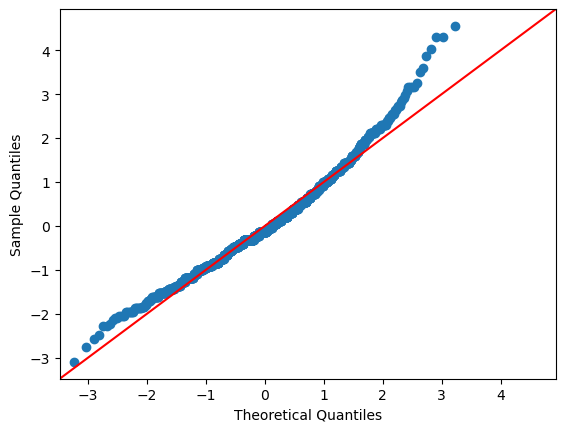

In [7]:
# Male QQPlot
fig = sm.qqplot(df[df['male']== 1].dropna()['diaBP'].values, stats.norm, fit=True, line="45")

By checking the histogram and qqplot of each category's BMI, and by the central limit theorem, we will assume normal distribution.

#### Calculating estimator of se:
$ s(x;\mu)  = \frac{\partial \log{f(x;\theta)}}{\partial \mu}; \theta=(\mu, \sigma^2); f(x;\theta)=\prod_{i=1}^{n} \frac{1}{\sigma\cdot \sqrt[2]{2\cdot\pi}}\cdot e^{(\frac{x_i-\mu}{\sigma})^2} \rightarrow l(x;\theta)=n\cdot\log{\frac{1}{\sigma\cdot \sqrt[2]{2\cdot\pi}}}-0.5\cdot\sum_{i=1}^{n}(\frac{x_i-\mu}{\sigma})^2
\\ \rightarrow \frac{\partial \log{f(x;\theta)}}{\partial \mu} = \frac{\sum_{i}^{n}(x_i-\mu)}{\sigma^2} \rightarrow I_n(\mu) = var(s(x;\theta)) = \frac{n}{\sigma^2} \rightarrow \hat{se}=\sqrt[2]{\frac{1}{\frac{n}{\hat{\sigma^2}}}} = \frac{1}{n}\cdot\sqrt[2]{\sum_{i}^{n}(x_i-\bar{x})^2}$

In [8]:
def get_confidence_level(df: pd.DataFrame):
    df['BMI_minus_average'] = (df['BMI'] - df['BMI'].mean())**2
    df_male = df[df['male'] == 1]
    df_female = df[df['male'] == 0]

    male_mle = df_male['BMI'].mean()
    female_mle = df_female['BMI'].mean()

    male_sum = df_male['BMI_minus_average'].sum()
    female_sum = df_male['BMI_minus_average'].sum()

    male_se = 1/len(df_male)*sqrt(male_sum)
    female_se = 1/len(df_female)*sqrt(female_sum)

    return (male_mle-2*male_se, male_mle+2*male_se), (female_mle-2*female_se, female_mle+2*female_se)

male_interval, female_interval = get_confidence_level(df)
print(f'Confidence interval for BMI mean for males:[{male_interval[0]}, {male_interval[1]}]')
print(f'Confidence interval for BMI mean for females:[{female_interval[0]}, {female_interval[1]}]')

Confidence interval for BMI mean for males:[26.024663306349975, 26.3466487112906]
Confidence interval for BMI mean for females:[25.391575519078792, 25.633696830193713]


As we can see, the two confidence intervals are not overlapping at all. The definition of confidence interval is that if we will calculate lots of confidence interval than with probability ~0.95 the real value of the mean will be in 95% of those intervals.
Since the male's interval & female's interval are not overlapping, it might implicate that their true means are not equal, but since the definition of confidence intervals requires many confidence intervals to be computed we cannot gurntee that conclusion.

### Hypothesis formulation
$H_0 : \mu_{male} - \mu_{female} = 0 \\
H_1 : \mu_{male} - \mu_{female} \neq 0$

### Assumptions of t test

In [9]:
df_male['normalized_BMI'] = (df_male['BMI'] - df_male['BMI'].mean())/df_male['BMI'].std()
df_female['normalized_BMI'] = (df_female['BMI']- df_female['BMI'].mean())/df_female['BMI'].std()

/home/dvir/anaconda3/envs/stats/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/dvir/anaconda3/envs/stats/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


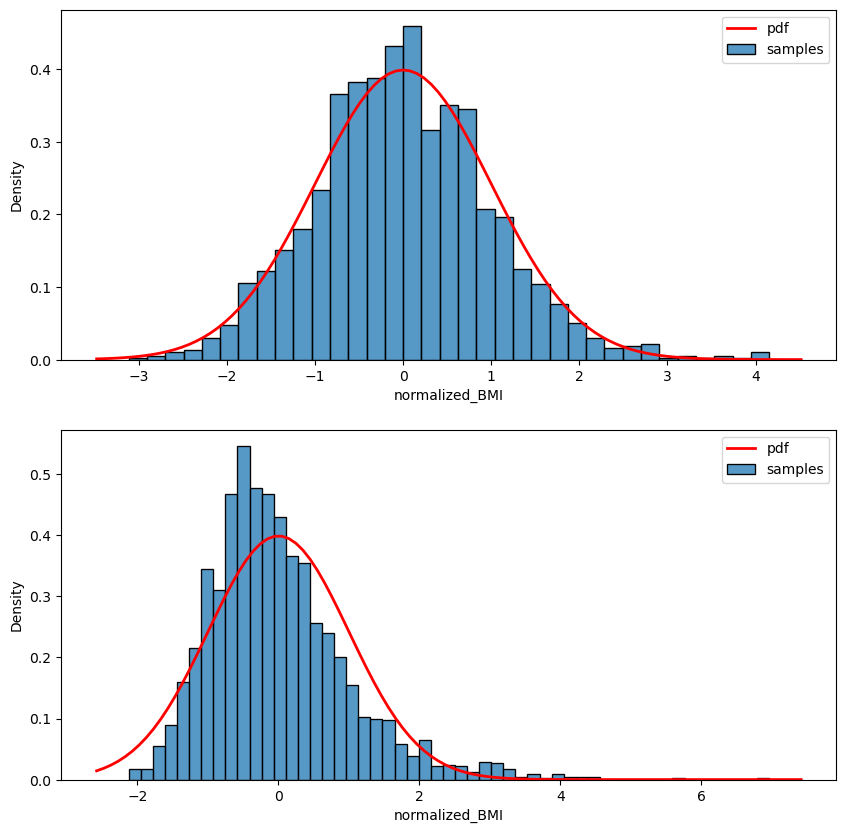

In [10]:
def plot_norm_hist(df, axes):
    sns.histplot(df['normalized_BMI'], kde=False, stat='density', label='samples', ax=axes)

    # calculate the pdf
    x0, x1 = axes.get_xlim()  # extract the endpoints for the x-axis
    x_pdf = np.linspace(x0, x1, 100)
    y_pdf = stats.norm.pdf(x_pdf)

    axes.plot(x_pdf, y_pdf, 'r', lw=2, label='pdf')                                                   
    axes.legend()

fig, axes = plt.subplots(2, figsize=(10,10))
plot_norm_hist(df_male, axes[0])
plot_norm_hist(df_female, axes[1])


Based on the above histograms, and as mentioned above (by the central limit theorem), we will assume that the t test assumptions of normality of the samples holds.

### T test

In [11]:
res = stats.ttest_ind(df_male['BMI'].dropna(), df_female['BMI'].dropna(), equal_var=False)
print(f'p-value = {res.pvalue}, statistic: {res.statistic}')

p-value = 3.498366291802098e-08, statistic: 5.524753445751446


We see that the p-value the t-test yielded is very low, than by the definition of p-value this means that there is a very low probability to get a more extreme result (two sided), hence we can reject the null hypothesis with high confidence level.

### Wald test

In [12]:
def walt_test(a, b, conf=None):
    """This function returns the p-value and the statistic's value of wald test applied to the difference of means of a & b"""
    a_mean = a.mean()
    b_mean = b.mean()
    a_var = a.std() ** 2
    b_var = b.std() ** 2
    a_len = len(a)
    b_len = len(b)
    t_stat = (a_mean - b_mean) / ((a_var / a_len) + (b_var / b_len)) ** 0.5
    return 2*norm.cdf(-abs(t_stat)), t_stat

In [13]:
res = walt_test(df_male['BMI'].dropna(), df_female['BMI'].dropna())
print(f'p-value = {res[0]}, statistic: {res[1]}')

p-value = 3.2994862416414765e-08, statistic: 5.5247534457508305


Once again, we get a very low p-value which leads us to the same conclusion from the t-test.

### 2.e Comparing t-test and wald test

As we can see, both t-test and wald test gives us a very low p-value and has the same statistic value, hence according to both we could reject the null hypothesis with high confidence level.

### 2.f Likelihood ratio test

As shown in previous sections, based on the historgram, qqplot and normal cdf plot, we will assume that both categorie's BMI values are drawn from normal distribution. For the purpose of this section, we will assume that both categories has the save variance. Hence, our hypothesis are:
$H_0 : \mu_{male} - \mu_{female} = 0 \\
H_1 : \mu_{male} - \mu_{female} \neq 0$

Based on some calculations attached in a pdf, our statistic results in:
$\lambda = \sum_{i=1}^{n}\frac{(x_i - \bar{Y})^2-(x_i - \bar{X})^2}{\sigma_{male}^2}$, where $x_i$ is an observation from the males and $y_i$ is an observation from the females, and $\bar{X}, \bar{Y}$ are their means respectfully.

Also, noticing that the total number of parameters for normal distribution is 2, and our hypothesises are checking one of them, hence the degrees of freedom is $ r=2, q=1 \rightarrow k=r-q=1 $

In [14]:
sigma_male = df_male['BMI'].std()**2
n = len(df_male)
x_bar = df_male['BMI'].mean()
y_bar = df_female['BMI'].mean()
males_minus_female_avg = (df_male['BMI'] - y_bar)**2
males_minus_male_avg = (df_male['BMI'] - x_bar)**2

lam = (1/sigma_male)*(males_minus_female_avg.sum()-males_minus_male_avg.sum())
ddof = 1
p_value = 1-chi2.cdf(lam, ddof)

In [15]:
print(f'p-value = {p_value}, statistic: {lam}')

p-value = 0.0, statistic: 70.35831124708764


### Comparing between previous sections

We can see that the p-value we got is zero while in the previous test it was very close to zero.

### 3.a Sampling randomly from the dataset

In [16]:
sizes = [30, 50, 100, 500]
dfs_list = []
for size in sizes:
    dfs_list.append(df.sample(size))

### 3.b + 3.c Confidence intervals and Wald test for each sample 

In [17]:
for df_sampled in dfs_list:
    print('Confidence intervals for size: ', len(df_sampled))
    male_interval, female_interval = get_confidence_level(df)
    print(f'Confidence interval for BMI mean for males:[{male_interval[0]}, {male_interval[1]}]')
    print(f'Confidence interval for BMI mean for females:[{female_interval[0]}, {female_interval[1]}]')
    print('')
    print('Wald test for size: ', len(df_sampled))
    res = walt_test(df_sampled[df['male']==1]['BMI'].dropna(), df_sampled[df['male']==0]['BMI'].dropna())
    print(f'p-value = {res[0]}, statistic: {res[1]}')
    print('')

Confidence intervals for size:  30
Confidence interval for BMI mean for males:[26.024663306349975, 26.3466487112906]
Confidence interval for BMI mean for females:[25.391575519078792, 25.633696830193713]

Wald test for size:  30
p-value = 0.3341598112825125, statistic: -0.9657689451018545

Confidence intervals for size:  50
Confidence interval for BMI mean for males:[26.024663306349975, 26.3466487112906]
Confidence interval for BMI mean for females:[25.391575519078792, 25.633696830193713]

Wald test for size:  50
p-value = 0.18804017167818388, statistic: 1.3163989589244138

Confidence intervals for size:  100
Confidence interval for BMI mean for males:[26.024663306349975, 26.3466487112906]
Confidence interval for BMI mean for females:[25.391575519078792, 25.633696830193713]

Wald test for size:  100
p-value = 0.2305399341553357, statistic: 1.1989691688538762

Confidence intervals for size:  500
Confidence interval for BMI mean for males:[26.024663306349975, 26.3466487112906]
Confidence 

/home/dvir/anaconda3/envs/stats/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


### 3.d Calculating confidence level & Wald test for each sample 100 times

In [18]:
def generate_intervals(df, size):
    male_intervals, female_intervals = [], []
    for i in range(iterations):
        temp_df = df.sample(size)
        male_interval, female_interval = get_confidence_level(temp_df)
        male_intervals.append(male_interval)
        female_intervals.append(female_interval)
    return male_intervals, female_intervals

In [19]:
def plot_confidence_intervals(mle, iterations: int, intervals: list, ax):
    j=0
    for i in range(iterations):
        curr_mle = sum(intervals[i])/2
        if (mle>intervals[i][0]) and (mle<intervals[i][1]):
            # interval contains p
            ax.errorbar(curr_mle, np.arange(iterations)[i],lolims=True, xerr=(intervals[i][1]-intervals[i][0])/2, yerr=0.0, linestyle='', c='black')
        else:
            # interval does not contain p
            ax.errorbar(curr_mle, np.arange(iterations)[i],lolims=True, xerr=(intervals[i][1]-intervals[i][0])/2, yerr=0.0, linestyle='', c='red')
            j +=1

    ax.axvline(mle, color='darkorange')
    ax.set_xlim(20,30)
    return j

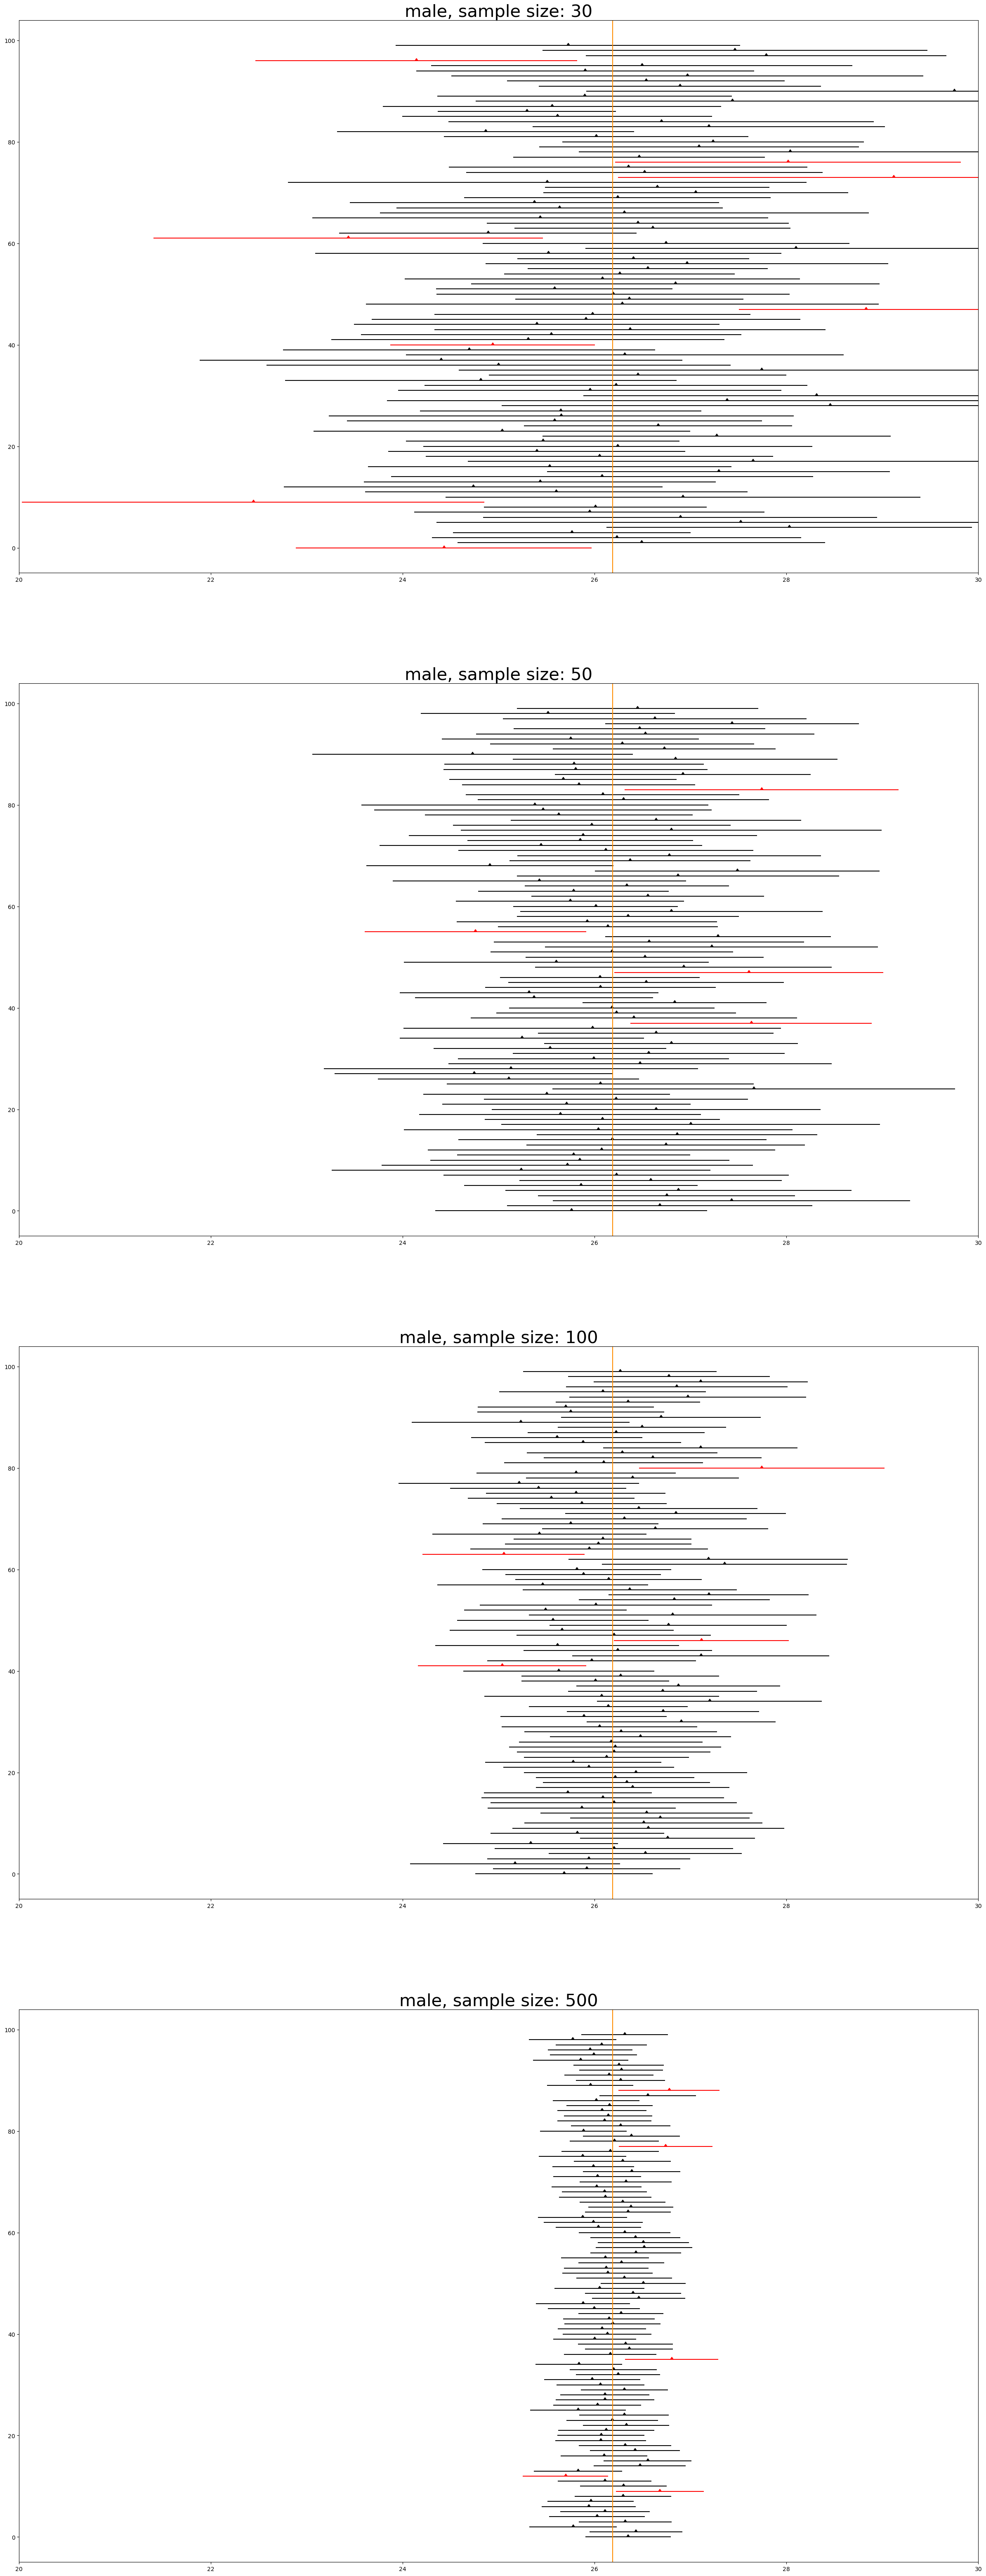

In [20]:
_, axes = plt.subplots(4, figsize=(30, 80))
iterations = 100
sizes = [30, 50, 100, 500]
male_num_of_bad_intervals = 0
for i, size in enumerate(sizes):
    male_intervals, female_intervals = generate_intervals(df, size)
    male_num_of_bad_intervals += plot_confidence_intervals(df[df['male']==1]['BMI'].mean(), iterations, male_intervals, axes[i])
    axes[i].set_title(f'male, sample size: {size}', fontsize= 30)


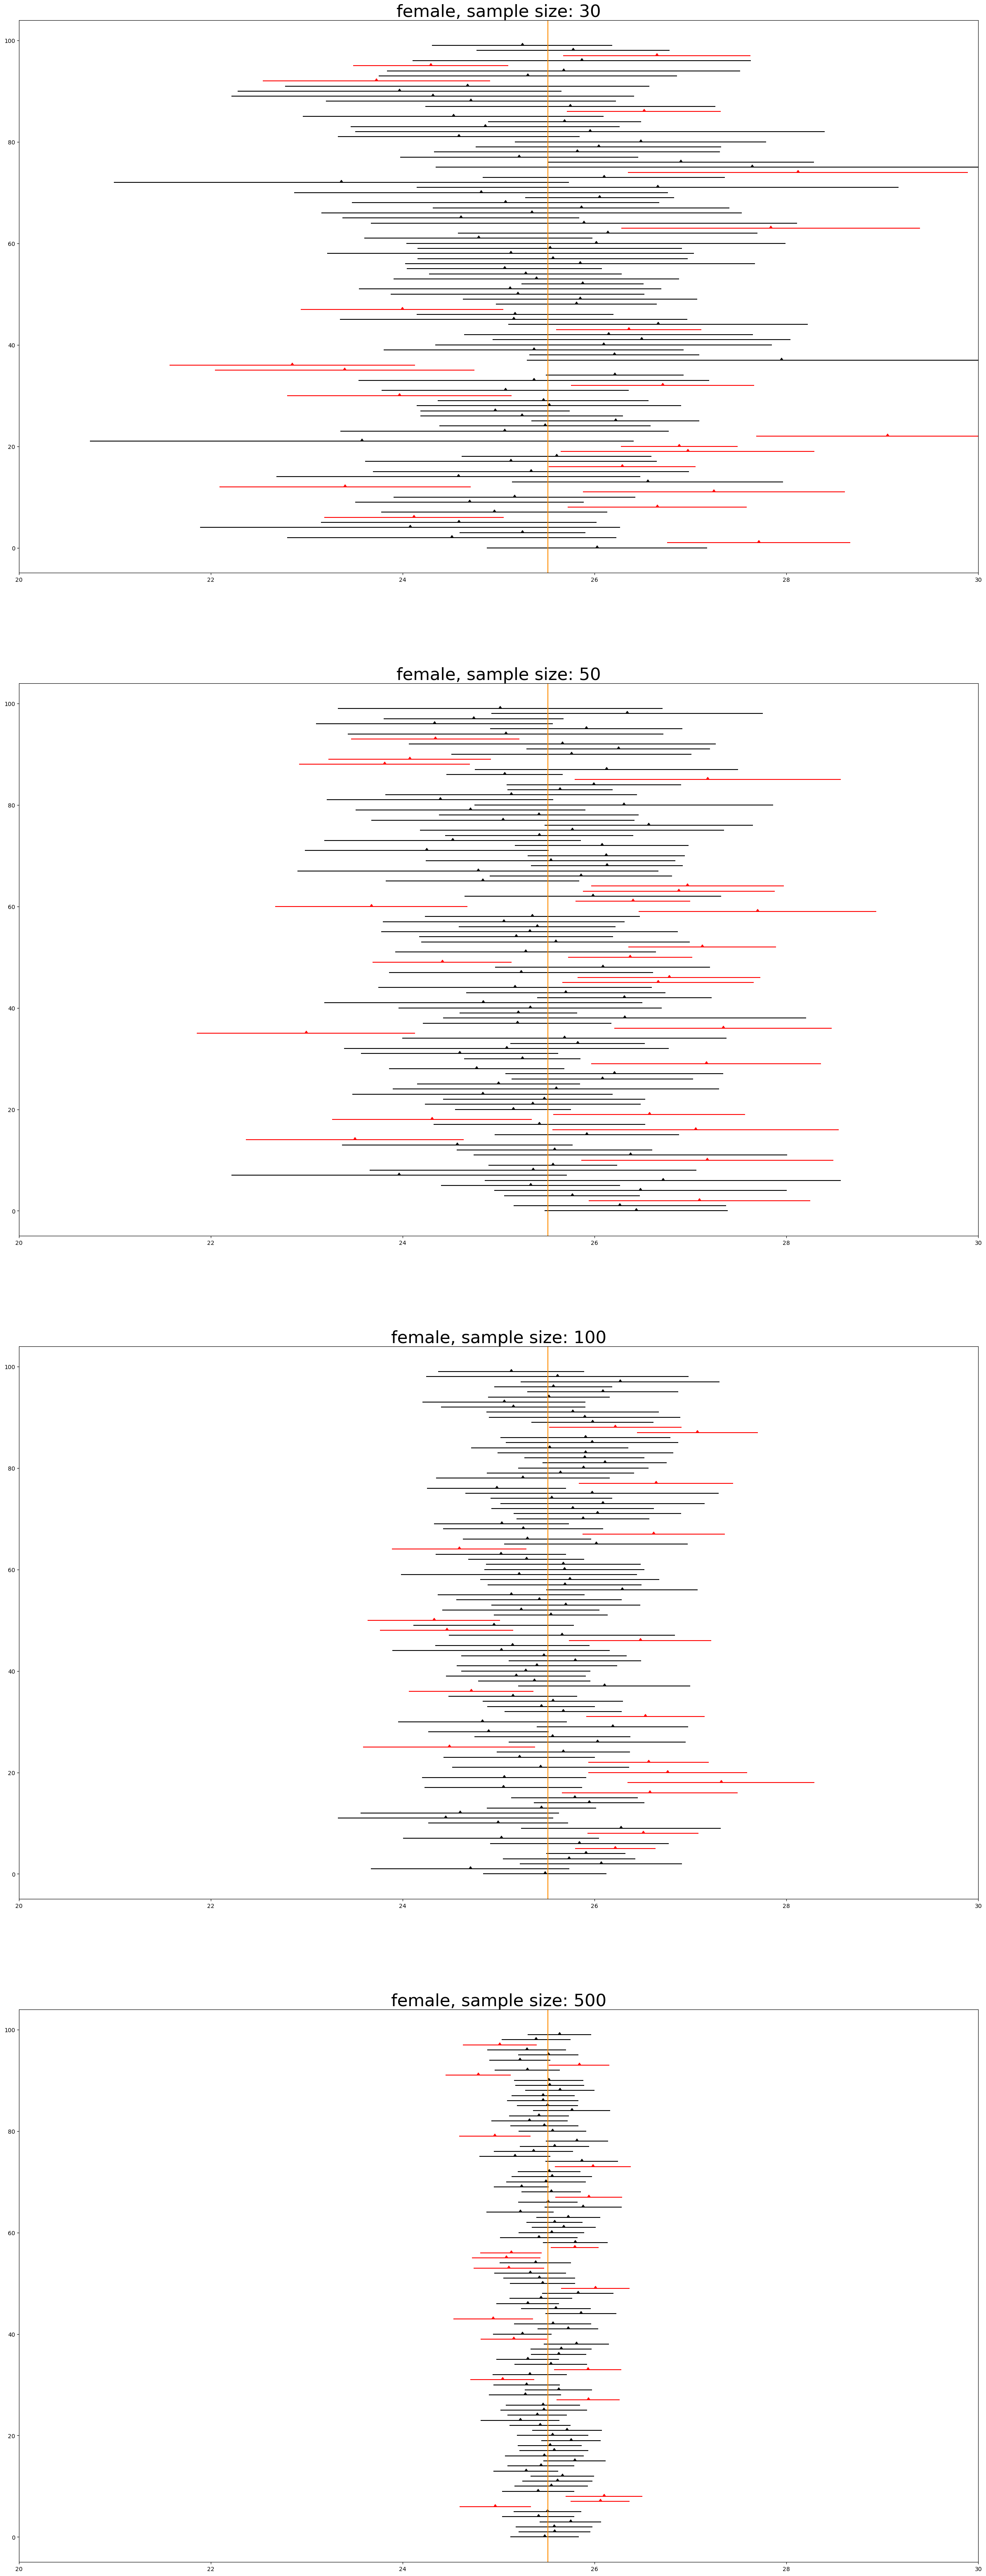

In [21]:
_, axes = plt.subplots(4, figsize=(30, 80))
iterations = 100
sizes = [30, 50, 100, 500]
female_num_of_bad_intervals = 0
for i, size in enumerate(sizes):
    male_intervals, female_intervals = generate_intervals(df, size)
    female_num_of_bad_intervals += plot_confidence_intervals(df[df['male']==0]['BMI'].mean(), iterations, female_intervals, axes[i])
    axes[i].set_title(f'female, sample size: {size}', fontsize= 30)

Let's check how many times the mle from section one fall inside the intervals

In [22]:
1-(female_num_of_bad_intervals / (400))

0.8

In [23]:
1-(male_num_of_bad_intervals / (400))

0.9475

As we can see, the confidence interval for males matches for a 95% confidence intervals, while the confidence intervals for females isn't an exact match for 95% and we assume it is because it has more noise in the data.

### Wald test for different sample sizes

In [24]:
iterations = 100
sizes = [30, 50, 100, 500]
male_num_of_bad_intervals = 0
avg_pvals = []
for i, size in enumerate(sizes):
    p_val = 0
    for _ in range(iterations):
        df_sampled = df.sample(size)
        df_sampled_male = df_sampled[df_sampled['male']==1]
        df_sampled_female = df_sampled[df_sampled['male']==0]
        res = walt_test(df_sampled_male['BMI'].dropna(), df_sampled_female['BMI'].dropna())
        p_val += res[0]
    avg_pvals.append(p_val/iterations)

In [25]:
avg_pvals

[0.4143852643223458,
 0.4634337850618771,
 0.37833272224201103,
 0.1796458298862724]

We can see that the average p-value is getting smaller for increasing sample sizes.